# Creating our database: 

In [2]:
import winning_chances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [3]:
mistake_bins = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]

#df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")

#table=winning_chances.compute_winning_chance_table(df)
#table=pd.read_csv("table_20.csv")
#table=pd.read_csv("winning_chances_all_moves.csv")
#summary_table=winning_chances.create_summary_table(df,mistake_bins=mistake_bins,winning_chance_table=table)


#summary_table=pd.read_csv("big_summary_table.csv")

summary_table=pd.read_csv("summary_table_20.csv")

# Linear Regression Model

In [4]:
# Import necessary libraries

# Parameters and features that might be adjusted
Number_of_Openings = 70  # Number of top openings to consider
Color_Player = 'White'   # Player color to analyze ('White' or 'Black')
categorical_features = ['Opening', 'Result']  # Initial categorical features
numerical_features = ['AWCL']                 # Initial numerical features
total_moves_bins = [0, 40, 60, 80, 100, 120, np.inf]  # Bins for total moves

# Preprocess 'Opening' column to group less frequent openings as 'Other'
top_openings = summary_table['Opening'].value_counts().nlargest(Number_of_Openings).index.tolist()
summary_table['Opening'] = summary_table['Opening'].apply(lambda x: x if x in top_openings else 'Other')

# Filter the summary table for the specified player color
new_summary_table = summary_table[summary_table['Player'] == Color_Player].copy()

# Define mistake labels based on columns after 'AWCL'
start_index = new_summary_table.columns.get_loc('AWCL') + 1
mistake_labels = list(new_summary_table.columns[start_index:])

# Update numerical features to include mistake labels
numerical_features += mistake_labels

# Define total moves labels based on the bins
total_moves_labels = [
    f'({total_moves_bins[i]},{total_moves_bins[i+1]}]' if not np.isinf(total_moves_bins[i + 1]) else f'({total_moves_bins[i]},∞]'
    for i in range(len(total_moves_bins) - 1)
]

# Create 'TotalMovesInterval' using pd.cut
new_summary_table['TotalMovesInterval'] = pd.cut(
    new_summary_table['TotalMoves'],
    bins=total_moves_bins,
    labels=total_moves_labels,
    right=True,
    include_lowest=True
)

# Add 'TotalMovesInterval' to categorical features
categorical_features.append('TotalMovesInterval')

# Handle missing values in the target variable
new_summary_table = new_summary_table.dropna(subset=['Elo'])

# Process categorical features
for col in categorical_features:
    # Convert to 'category' dtype
    new_summary_table[col] = new_summary_table[col].astype('category')
    # Add 'Unknown' to categories if not present
    if 'Unknown' not in new_summary_table[col].cat.categories:
        new_summary_table[col] = new_summary_table[col].cat.add_categories(['Unknown'])
    # Fill NaN values with 'Unknown'
    new_summary_table[col] = new_summary_table[col].fillna('Unknown')

# Handle missing values in numerical features (mistake intervals)
new_summary_table[numerical_features] = new_summary_table[numerical_features].fillna(0)

# Define target variable
y = new_summary_table['Elo']

# Define features
X = new_summary_table[categorical_features + numerical_features]

# Split the data with stratification on binned 'Elo' values
y_binned = pd.qcut(y, q=10, duplicates='drop')

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=40,
    stratify=y_binned
)

# Create a ColumnTransformer to apply OneHotEncoder to categorical features and StandardScaler to numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Create a pipeline with KNN Regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(
        n_neighbors=5,    # Number of neighbors to use
        weights='uniform' # Weight function used in prediction
    ))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Calculate percentage of predictions within a threshold
absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")
print(f"min: {y_pred.min()}")
print(f"max: {y_pred.max()}")
print(f"mean: {y_pred.mean()}")

Root Mean Squared Error (RMSE): 279.63
R-squared Score (R²): 0.01
Percentage of predictions within ±300 Elo: 72.89%
min: 1577.2
max: 2642.4
mean: 2218.230239144116


# Graphs and observations

In [ ]:


# Compute permutation importances on the test set
result = permutation_importance(
    pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

# Get feature names after preprocessing
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([onehot_feature_names, numerical_features])

# Create a DataFrame with feature importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean
})

# Take the absolute value of importances to handle negative values
feature_importances['Importance'] = feature_importances['Importance'].abs()

# Get the feature importances for mistake labels
mistake_feature_importances = feature_importances[feature_importances['Feature'].isin(mistake_labels)]

# Create a dictionary of mistake importances
mistake_importances = mistake_feature_importances.set_index('Feature')['Importance'].to_dict()

# Compute 'WeightedMistakeScore' using the importances
coefficients_series = pd.Series(mistake_importances)
# Fill missing coefficients with zero to match mistake_labels
coefficients_series = coefficients_series.reindex(mistake_labels, fill_value=0)
new_summary_table['WeightedMistakeScore'] = new_summary_table[mistake_labels].dot(coefficients_series)

# Proceed with creating Elo bins and plotting as before

# Step 3: Create Elo bins and labels
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]
elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1] - 1  # Subtract 1 to make the upper limit inclusive
    label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)

# Assign Elo bins to the data
new_summary_table['EloBin'] = pd.cut(
    new_summary_table['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False,        # Left-inclusive intervals
    include_lowest=True # Include the lowest value
)

# Remove rows with missing 'EloBin' values (if any)
new_summary_table = new_summary_table.dropna(subset=['EloBin'])

# Step 4: Compute average 'WeightedMistakeScore' per Elo bin
avg_mistake_per_elo_bin = new_summary_table.groupby('EloBin')['WeightedMistakeScore'].mean().reset_index()

# Step 5: Plot the line graph connecting the averages
plt.figure(figsize=(10, 6))
plt.plot(avg_mistake_per_elo_bin['EloBin'], avg_mistake_per_elo_bin['WeightedMistakeScore'], marker='o')
plt.title('Average Weighted Mistake Score per Elo Rating Bin (KNN Model)')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Weighted Mistake Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [97]:
# Assume all necessary libraries are already imported and previous code has been executed
# The pipeline 'pipeline' has been trained, and 'categorical_features', 'numerical_features',
# and 'top_openings' are defined from your previous code.

# Step 1: Select 20 games with Elo < 1500
# Use the original 'new_summary_table' and filter for the specified player color if needed
new_summary_table_low_elo = new_summary_table[new_summary_table['Elo'] < 1500].copy()

# Check if there are at least 20 games; if not, adjust accordingly
if len(new_summary_table_low_elo) < 20:
    print(f"Only {len(new_summary_table_low_elo)} games found with Elo < 1500.")
    sample_games = new_summary_table_low_elo
else:
    # Randomly select 20 games
    sample_games = new_summary_table_low_elo.sample(n=20, random_state=42)

# Step 2: Preprocess the selected games

# Ensure the 'Opening' column is processed the same way as in training
# If 'top_openings' was used to group less frequent openings under 'Other', apply the same here
sample_games['Opening'] = sample_games['Opening'].apply(lambda x: x if x in top_openings else 'Other')

# Process categorical features
for col in categorical_features:
    sample_games[col] = sample_games[col].astype('category')
    # Ensure the categories match those in the training set
    sample_games[col] = sample_games[col].cat.set_categories(new_summary_table[col].cat.categories)
    # Fill NaN values with 'Unknown'
    sample_games[col] = sample_games[col].fillna('Unknown')

# Handle missing values in numerical features
sample_games[numerical_features] = sample_games[numerical_features].fillna(0)

# Define features for prediction
X_new = sample_games[categorical_features + numerical_features]

# Step 3: Predict using the trained model
y_new_pred = pipeline.predict(X_new)

# Step 4: Output the predictions per game
sample_games = sample_games.reset_index(drop=True)  # Reset index for clarity
sample_games['Predicted_Elo'] = y_new_pred

# Display the predictions per game
print("Predictions for each game:")
print(sample_games[['GameID', 'Elo', 'Predicted_Elo']])

# Step 5: Compute and display average, min, and max of the predictions
average_pred = y_new_pred.mean()
min_pred = y_new_pred.min()
max_pred = y_new_pred.max()

print(f"\nAverage Predicted Elo: {average_pred:.2f}")
print(f"Minimum Predicted Elo: {min_pred:.2f}")
print(f"Maximum Predicted Elo: {max_pred:.2f}")


Predictions for each game:
     GameID     Elo  Predicted_Elo
0   34775.0  1418.0        2134.87
1   34693.0  1344.0        1622.91
2    4850.0  1352.0        1658.91
3   34696.0  1265.0        2163.83
4   24371.0  1451.0        1749.14
5    9542.0  1407.0        1759.71
6    4921.0  1349.0        1647.76
7   26473.0  1495.0        1795.12
8   15989.0  1498.0        1674.43
9    4801.0  1061.0        1929.30
10   4012.0  1349.0        1684.84
11   4378.0  1241.0        1445.23
12   5258.0  1372.0        1639.36
13   4672.0  1475.0        1773.00
14  18295.0  1396.0        1614.22
15   4408.0  1207.0        1372.85
16   7551.0  1408.0        1744.39
17  21568.0  1357.0        1599.59
18  34746.0  1450.0        1780.55
19   4265.0  1168.0        1570.45

Average Predicted Elo: 1718.02
Minimum Predicted Elo: 1372.85
Maximum Predicted Elo: 2163.83


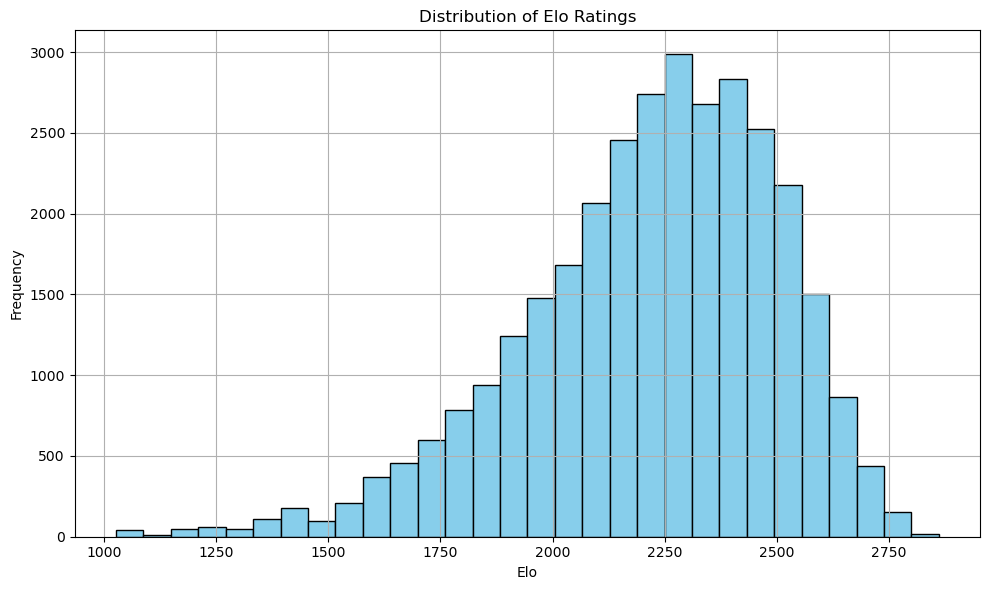

In [60]:
#Histogram of Elo Distribution (Stratification Justification):

plt.figure(figsize=(10, 6))
plt.hist(new_summary_table['Elo'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Elo Ratings')
plt.xlabel('Elo')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


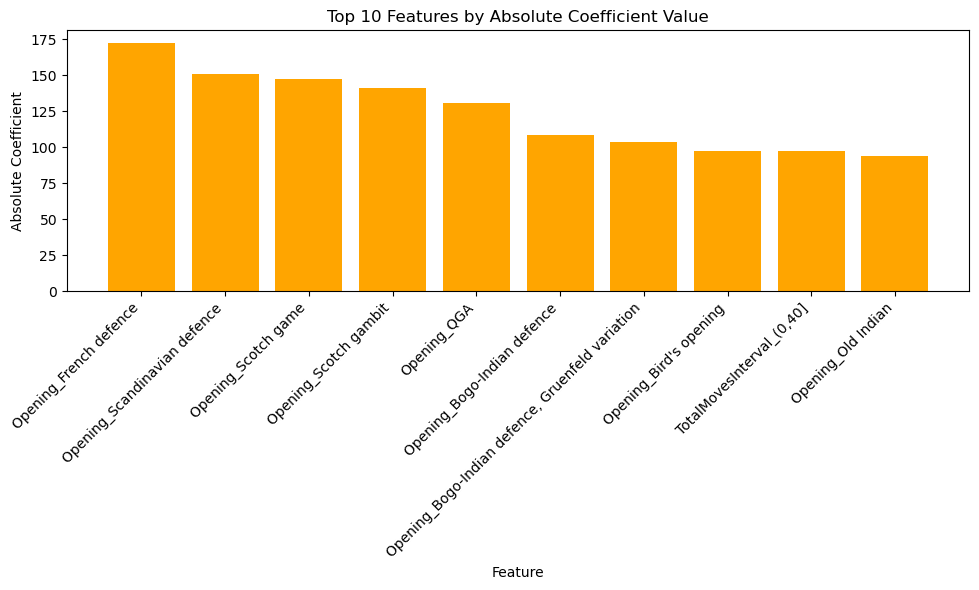

In [61]:
# Feature Importance Bar Chart
top_features = coef_df.head(10)  # Top 10 features by absolute value
plt.figure(figsize=(10, 6))
plt.bar(top_features['Feature'], top_features['AbsCoefficient'], color='orange')
plt.title('Top 10 Features by Absolute Coefficient Value')
plt.xlabel('Feature')
plt.ylabel('Absolute Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

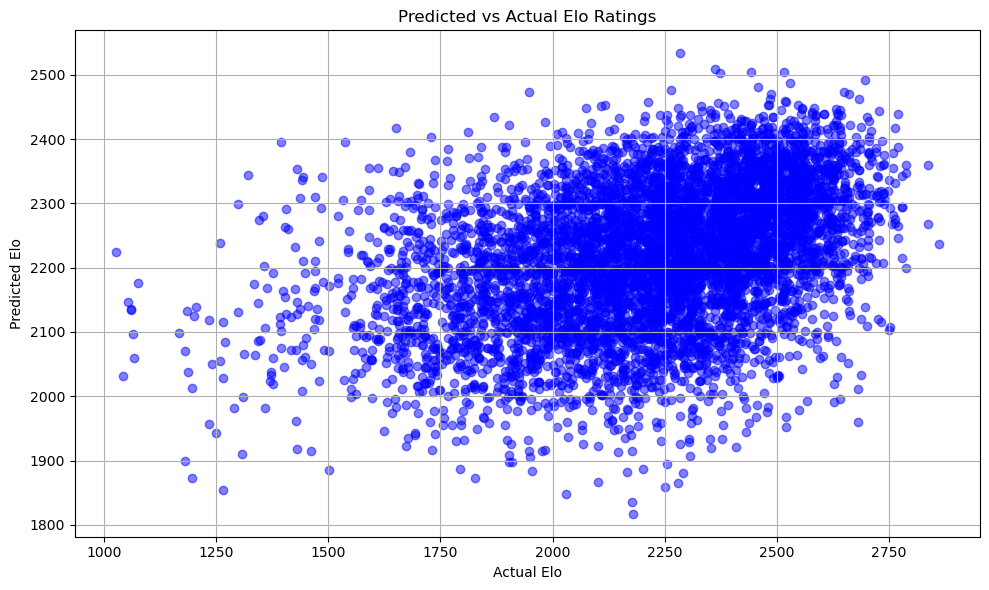

In [62]:
#Scatter Plot of Predicted vs Actual Elo:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.title('Predicted vs Actual Elo Ratings')
plt.xlabel('Actual Elo')
plt.ylabel('Predicted Elo')
plt.grid(True)
plt.tight_layout()
plt.show()

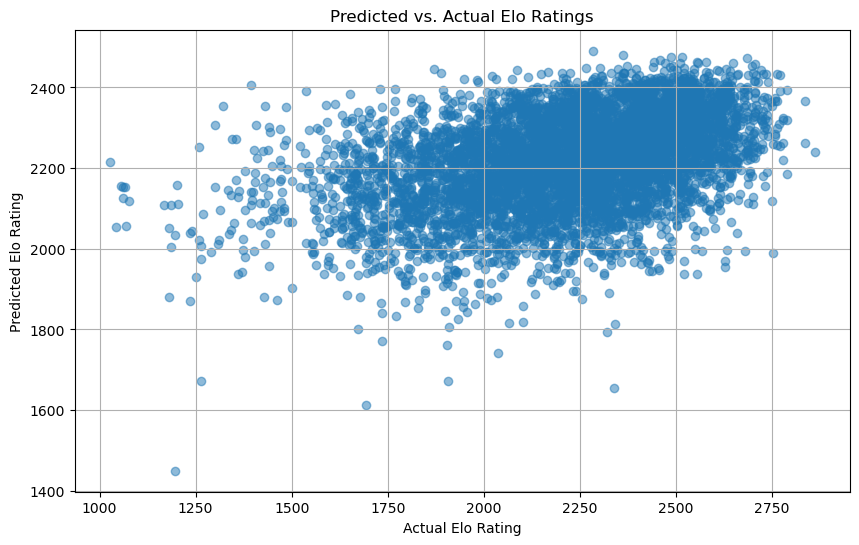

In [8]:

# Plot Predicted vs. Actual Elo Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Predicted vs. Actual Elo Ratings')
plt.xlabel('Actual Elo Rating')
plt.ylabel('Predicted Elo Rating')
plt.grid(True)
plt.show()


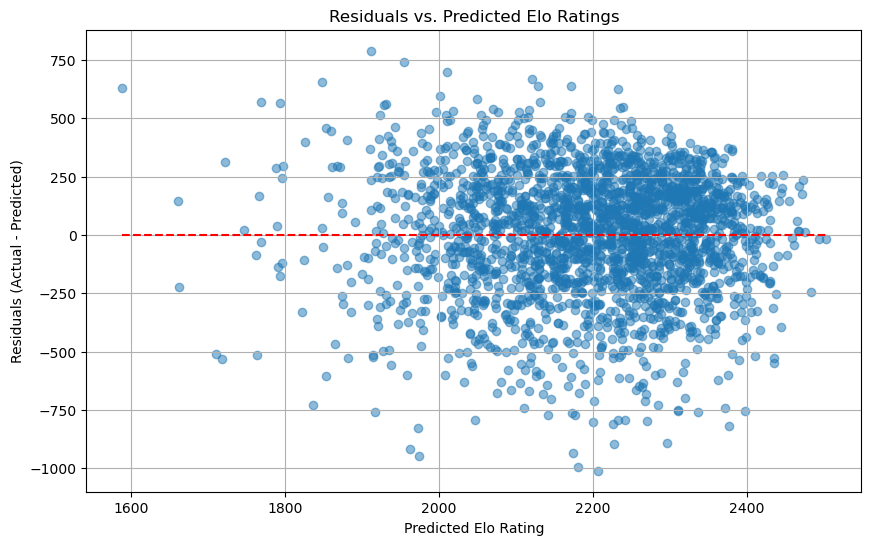

In [79]:
# Calculate residuals
residuals = y_test - y_pred

# Plot Residuals vs. Predicted Elo Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='dashed')
plt.title('Residuals vs. Predicted Elo Ratings')
plt.xlabel('Predicted Elo Rating')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()


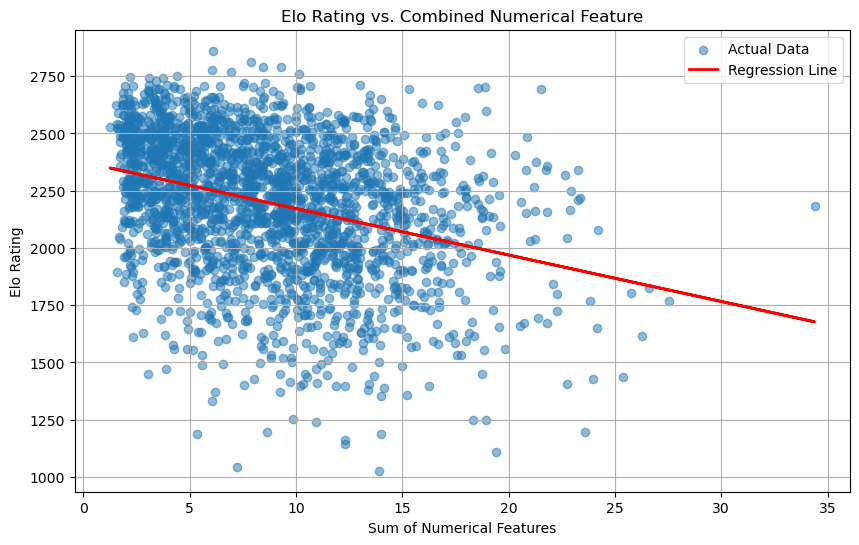

In [80]:
# Combine numerical features into a single feature
X_combined = X[numerical_features].sum(axis=1)
# Reshape X_combined for model fitting
X_combined_reshaped = X_combined.values.reshape(-1, 1)

# Split the combined data
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined_reshaped, y, test_size=0.2, random_state=40
)

# Create and train a new linear regression model
model_combined = LinearRegression()
model_combined.fit(X_train_combined, y_train_combined)
# Predict using the combined feature
y_pred_combined = model_combined.predict(X_test_combined)

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_test_combined, y_test_combined, alpha=0.5, label='Actual Data')
plt.plot(X_test_combined, y_pred_combined, color='red', linewidth=2, label='Regression Line')
plt.title('Elo Rating vs. Combined Numerical Feature')
plt.xlabel('Sum of Numerical Features')
plt.ylabel('Elo Rating')
plt.legend()
plt.grid(True)
plt.show()


# Creating table based on train/test set

In [ ]:
df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=40)

table_train = winning_chances.compute_winning_chance_table(df_train)
table_test = winning_chances.compute_winning_chance_table(df_test)

# Create summary tables for training and testing sets
summary_table_train = winning_chances.create_summary_table(df_train, mistake_bins=mistake_bins, winning_chance_table=table_train)
summary_table_test = winning_chances.create_summary_table(df_test, mistake_bins=mistake_bins, winning_chance_table=table_test)


In [ ]:
numerical_features=['AWCL']
categorical_features=['Opening', 'Result', 'TotalMovesInterval']
total_moves_bins=[0, 40,  60,  80,  100, 120, np.inf] 
mistake_bins=[5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]
Opening_number=70 
Color_Player='White'
    
    
    

# Process the training summary table
top_openings = summary_table_train['Opening'].value_counts().nlargest(Opening_number).index.tolist()
summary_table_train['Opening'] = summary_table_train['Opening'].apply(lambda x: x if x in top_openings else 'Other')

new_summary_table_train = summary_table_train[summary_table_train['Player'] == Color_Player].copy()

# Define mistake labels based on columns after 'AWCL'
start_index = new_summary_table_train.columns.get_loc('AWCL') + 1
mistake_labels = list(new_summary_table_train.columns[start_index:])

# Update numerical features to include mistake labels and 'AWCL'
numerical_features = numerical_features + mistake_labels 

# Create 'TotalMovesInterval' using pd.cut
total_moves_labels = [
    f'({total_moves_bins[i]},{total_moves_bins[i+1]}]' if not np.isinf(total_moves_bins[i + 1]) else f'({total_moves_bins[i]},∞]'
    for i in range(len(total_moves_bins) - 1)
]

# Create 'TotalMovesInterval' using pd.cut
new_summary_table_train['TotalMovesInterval'] = pd.cut(
    new_summary_table_train['TotalMoves'],
    bins=total_moves_bins,
    labels=total_moves_labels,
    right=True,
    include_lowest=True
)

# Handle missing values in the target variable
new_summary_table_train = new_summary_table_train.dropna(subset=['Elo'])

# Process categorical features in the training set
for col in categorical_features:
    new_summary_table_train[col] = new_summary_table_train[col].astype('category')
    if 'Unknown' not in new_summary_table_train[col].cat.categories:
        new_summary_table_train[col] = new_summary_table_train[col].cat.add_categories(['Unknown'])
    new_summary_table_train[col] = new_summary_table_train[col].fillna('Unknown')

# Handle missing values in numerical features
new_summary_table_train[numerical_features] = new_summary_table_train[numerical_features].fillna(0)

# Define target variable and features for training
y_train = new_summary_table_train['Elo']
X_train = new_summary_table_train[categorical_features + numerical_features]

# Process the testing summary table
summary_table_test['Opening'] = summary_table_test['Opening'].apply(lambda x: x if x in top_openings else 'Other')

new_summary_table_test = summary_table_test[summary_table_test['Player'] == Color_Player].copy()

new_summary_table_test['TotalMovesInterval'] = pd.cut(
    new_summary_table_test['TotalMoves'],
    bins=total_moves_bins,
    labels=total_moves_labels,
    right=True,
    include_lowest=True
)

new_summary_table_test = new_summary_table_test.dropna(subset=['Elo'])

# Process categorical features in the testing set
for col in categorical_features:
    new_summary_table_test[col] = new_summary_table_test[col].astype('category')
    # Ensure the categories match those in the training set
    new_summary_table_test[col] = new_summary_table_test[col].cat.set_categories(new_summary_table_train[col].cat.categories)
    new_summary_table_test[col] = new_summary_table_test[col].fillna('Unknown')

# Handle missing values in numerical features
new_summary_table_test[numerical_features] = new_summary_table_test[numerical_features].fillna(0)

# Define target variable and features for testing
y_test = new_summary_table_test['Elo']
X_test = new_summary_table_test[categorical_features + numerical_features]

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features unchanged
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Calculate percentage of predictions within a threshold
absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")

# Get the names of the categorical features after one-hot encoding
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine with numerical feature names
all_feature_names = np.concatenate([onehot_feature_names, numerical_features])
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Sort the coefficients by absolute value
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Display the top 5 features with the highest absolute coefficients
print("\nTop 5 features by absolute coefficient value:")
print(coef_df[['Feature', 'Coefficient']].head(5))

# Display the coefficients for the mistake labels
mistake_coef_df = coef_df[coef_df['Feature'].isin(mistake_labels)]
print("\nCoefficients for the mistake labels:")
print(mistake_coef_df[['Feature', 'Coefficient']])